# Helper Functions

In [105]:
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
from pycocotools.coco import COCO
from collections import OrderedDict

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

def get_bin(num_objects):
    if num_objects <= 1:
        return 1
    elif num_objects <= 5:
        return 2
    elif num_objects <= 9:
        return 3
    elif num_objects <= 17:
        return 4
    else:
        return 5

dataset_path = "/opt/ml/input/data"
anns_file_path = dataset_path + '/' + 'train_all.json'
coco = COCO(anns_file_path)

loading annotations into memory...
Done (t=3.97s)
creating index...
index created!


# Train DataFrame

In [106]:
alldata = pd.DataFrame()

coco = COCO(anns_file_path)
image_ids = coco.getImgIds()
cat_ids = coco.getCatIds()
cats = coco.loadCats(cat_ids)
category_names = ['UNKNOWN','General trash','Paper','Paper pack','Metal',
                    'Glass','Plastic','Styrofoam','Plastic bag','Battery','Clothing']

for image_id in tqdm(image_ids):
    image_infos = coco.loadImgs(image_id)[0]
    image_path = dataset_path + '/' + image_infos['file_name']
    anns_ids = coco.getAnnIds(imgIds=image_id)
    anns = coco.loadAnns(anns_ids)
    bin = get_bin(len(anns))
    info = OrderedDict({key:0 for key in category_names})
    info['image_id'] = image_id
    info['path'] = image_path
    info['num_objects'] = len(anns)
    info['bin'] = bin
    info['width'] = image_infos['width']
    info['height'] = image_infos['height']
    for ann in anns:
        className = get_classname(ann['category_id'], cats)
        info[className]+=1
    alldata = alldata.append(info,ignore_index=True)
    

loading annotations into memory...
Done (t=4.26s)
creating index...
index created!


100%|██████████| 3272/3272 [00:17<00:00, 190.88it/s]


In [107]:
alldata['bin']=alldata['bin'].astype(np.int32)
alldata['image_id']=alldata['image_id'].astype(np.int32)
alldata['num_objects']=alldata['num_objects'].astype(np.int32)
alldata['height']=alldata['height'].astype(np.int32)
alldata['width']=alldata['width'].astype(np.int32)
alldata[category_names] = alldata[category_names].astype(np.int32)
alldata = alldata[['image_id','path','width','height','num_objects','bin']+category_names]

In [108]:
pd.options.display.max_colwidth=100
alldata

,image_id,path,width,height,num_objects,bin,UNKNOWN,General trash,Paper,Paper pack,Metal,Glass,Plastic,Styrofoam,Plastic bag,Battery,Clothing
0,0,/opt/ml/input/data/batch_01_vt/0002.jpg,512,512,17,4,0,0,0,0,0,4,4,0,9,0,0
1,1,/opt/ml/input/data/batch_01_vt/0003.jpg,512,512,14,4,0,8,0,0,0,0,0,0,6,0,0
2,2,/opt/ml/input/data/batch_01_vt/0005.jpg,512,512,1,1,0,0,0,0,0,0,1,0,0,0,0
3,3,/opt/ml/input/data/batch_01_vt/0006.jpg,512,512,2,2,0,0,0,0,1,0,1,0,0,0,0
4,4,/opt/ml/input/data/batch_01_vt/0007.jpg,512,512,2,2,0,0,0,0,0,0,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3267,3267,/opt/ml/input/data/batch_03/0994.jpg,512,512,7,3,0,0,2,0,0,0,2,2,1,0,0
3268,3268,/opt/ml/input/data/batch_03/0995.jpg,512,512,14,4,0,0,12,0,1,0,0,0,1,0,0
3269,3269,/opt/ml/input/data/batch_03/0996.jpg,512,512,4,2,0,2,1,0,0,0,0,1,0,0,0
3270,3270,/opt/ml/input/data/batch_03/0997.jpg,512,512,8,3,0,0,8,0,0,0,0,0,0,0,0


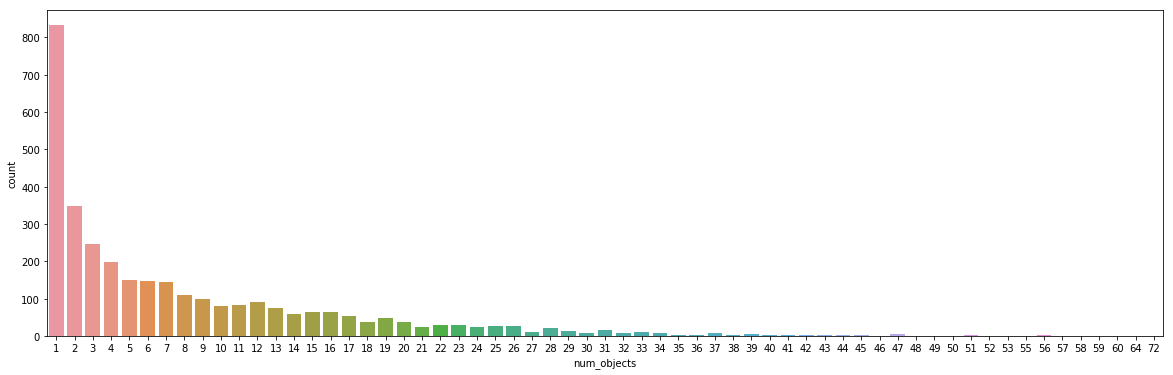

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
ax = sns.countplot(x="num_objects", data=alldata)

In [110]:
alldata['num_objects'].value_counts()

1     832
2     348
3     245
4     198
5     150
     ... 
57      1
49      1
53      1
55      1
72      1
Name: num_objects, Length: 61, dtype: int64

In [111]:
distribution = alldata['num_objects'].value_counts().values

In [112]:
distribution[17:].sum()

433

In [113]:
# distribution[1:].sum()/4 = 610
# 0, [1:4], [5:8], [9:16], [17:]
distribution[1:3].sum()

593

In [114]:
alldata.to_csv("/opt/ml/code/alldata.csv",index=0)

# Test DataFrame

In [115]:
testdata = pd.DataFrame()

dataset_path = "/opt/ml/input/data"
anns_file_path = dataset_path + '/' + 'test.json'
coco = COCO(anns_file_path)
image_ids = coco.getImgIds()
cat_ids = coco.getCatIds()
cats = coco.loadCats(cat_ids)

resize_size = 256

for image_id in tqdm(image_ids):
    image_infos = coco.loadImgs(image_id)[0]
    image_path = dataset_path + '/' + image_infos['file_name']
    info = OrderedDict()
    info['image_id'] = image_id
    info['path'] = image_path
    info['width'] = resize_size
    info['height'] = resize_size
    testdata = testdata.append(info,ignore_index=True)
    

  4%|▎         | 30/837 [00:00<00:02, 290.92it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


100%|██████████| 837/837 [00:02<00:00, 282.27it/s]


In [116]:
testdata['image_id']=testdata['image_id'].astype(np.int32)
testdata['height']=testdata['height'].astype(np.int32)
testdata['width']=testdata['width'].astype(np.int32)
testdata = testdata[['image_id','path','width','height']]

In [117]:
testdata

,image_id,path,width,height
0,0,/opt/ml/input/data/batch_01_vt/0021.jpg,256,256
1,1,/opt/ml/input/data/batch_01_vt/0028.jpg,256,256
2,2,/opt/ml/input/data/batch_01_vt/0031.jpg,256,256
3,3,/opt/ml/input/data/batch_01_vt/0032.jpg,256,256
4,4,/opt/ml/input/data/batch_01_vt/0070.jpg,256,256
...,...,...,...,...
832,832,/opt/ml/input/data/batch_03/0947.jpg,256,256
833,833,/opt/ml/input/data/batch_03/0968.jpg,256,256
834,834,/opt/ml/input/data/batch_03/0969.jpg,256,256
835,835,/opt/ml/input/data/batch_03/0992.jpg,256,256


In [118]:
testdata.to_csv("/opt/ml/code/testdata.csv",index=0)

In [119]:
testdata = pd.read_csv("/opt/ml/code/testdata.csv")

In [120]:
testdata

,image_id,path,width,height
0,0,/opt/ml/input/data/batch_01_vt/0021.jpg,256,256
1,1,/opt/ml/input/data/batch_01_vt/0028.jpg,256,256
2,2,/opt/ml/input/data/batch_01_vt/0031.jpg,256,256
3,3,/opt/ml/input/data/batch_01_vt/0032.jpg,256,256
4,4,/opt/ml/input/data/batch_01_vt/0070.jpg,256,256
...,...,...,...,...
832,832,/opt/ml/input/data/batch_03/0947.jpg,256,256
833,833,/opt/ml/input/data/batch_03/0968.jpg,256,256
834,834,/opt/ml/input/data/batch_03/0969.jpg,256,256
835,835,/opt/ml/input/data/batch_03/0992.jpg,256,256


# 데이터셋 리사이즈

In [121]:
import cv2

image_list = testdata['path'].values

for image_path in image_list:
    image = cv2.imread(image_path)
    image = cv2.resize(image,
                       (256,256),
                       interpolation = cv2.INTER_CUBIC)
    cv2.imwrite(image_path,image)